In [1]:
import os
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import tifffile
from einops import rearrange
from ome_types import OME, from_tiff, from_xml
from scipy.ndimage import binary_fill_holes, binary_erosion, binary_dilation
from skimage.segmentation import expand_labels


/home/estorrs/.local/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/miniconda/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## utils

###### input data

In [2]:


def adata_from_xenium(filepath, scaler=.1, normalize=False, transcripts=False, base=np.e):
    adata = sc.read_10x_h5(
        filename=os.path.join(filepath, 'cell_feature_matrix.h5')
    )

    df = pd.read_csv(
        os.path.join(filepath, 'cells.csv.gz')
    )
    df = df.set_index('cell_id')
    adata.obs = df.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy().astype(int)

    if os.path.exists(os.path.join(filepath, 'morphology_focus.ome.tif')):
        fp = os.path.join(filepath, 'morphology_focus.ome.tif')
        dim_order = 'w c'
    elif os.path.exists(os.path.join(filepath, 'morphology.ome.tif')):
        fp = os.path.join(filepath, 'morphology_focus', 'morphology_focus_0000.ome.tif')
        dim_order = 'c h w'
    else:
        raise RuntimeError(f'Could not find morphology.ome.tif')

    adata.uns['ome'] = from_tiff(fp).model_dump_json()
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=5)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)

    return adata


def tile_xenium(adata, target_size=None, tile_size=10, transcripts=None, genes=None):
    if target_size is None:
#         target_size = xenium.get_fullres_size(adata)
        model = json.loads(adata.uns['ome'])
        h, w = model['images'][0]['pixels']['size_y'], model['images'][0]['pixels']['size_x']
        upp = model['images'][0]['pixels']['physical_size_y']
        target_size = (int(h * upp), int(w * upp))
    
    if transcripts is None:
        if genes is not None:
            adata = adata[:, genes]

        adata.obs['grid_name'] = [f'{x // tile_size}_{y // tile_size}'
                                  for x, y in adata.obsm['spatial'].astype(int)]
        df = pd.DataFrame(
            data=adata.X,
            columns=adata.var.index.to_list(),
            index=adata.obs.index.to_list()
        )
        df['grid_name'] = adata.obs['grid_name'].to_list()
        df = df.groupby('grid_name').sum()    
    else:
        transcripts['grid_name'] = [
            f'{x // tile_size}_{y // tile_size}'
            for x, y in transcripts[['x_location', 'y_location']].values.astype(int)]

        df = transcripts[['feature_name', 'grid_name', 'transcript_id']].groupby(['feature_name', 'grid_name']).count()
        df = df.reset_index()
        df = df.pivot_table(index=['grid_name'], columns=['feature_name'])
        df = df.replace(np.nan, 0)
        df.columns = [c for _, c in list(df.columns)]
        df = df[[c for c in df.columns if 'Codeword' not in c and 'NegControl' not in c]] # get rid of weird feature names

    img = np.zeros((target_size[0] // tile_size + 1, target_size[1] // tile_size + 1, df.shape[1]))
    for name, row in df.iterrows():
        x, y = [int(x) for x in name.split('_')]
        img[y, x] = row.values

    if transcripts is None:
        return img
    else:
        return img, list(df.columns)

###### transcript counting

In [3]:
from __future__ import annotations

def count_genes_in_regions(
    label_img: np.ndarray,
    spots: pd.DataFrame,
    *,
    per_gene: bool = False,
    aggregate: str = "unique",
) -> pd.DataFrame:
    """"""
    required = {"gene", "x", "y"}
    if not required.issubset(spots.columns):
        raise ValueError(f"`spots` must contain columns {sorted(required)}")

    # Convert coordinates to int64 NumPy arrays (vectorised, no Python loops)
    x = spots["x"].to_numpy(np.int64)
    y = spots["y"].to_numpy(np.int64)

    h, w = label_img.shape
    if (x < 0).any() or (y < 0).any() or (x >= w).any() or (y >= h).any():
        raise ValueError("Some x/y coordinates fall outside label_img bounds")

    # Look up the region ID for every spot in one call
    region_ids = label_img[y, x]

    # Keep only spots that overlap a region (>0)
    mask = region_ids > 0
    if not mask.any():
        return pd.DataFrame()

    df = spots.loc[mask].assign(region_id=region_ids[mask])

    if per_gene:
        # Region × gene matrix (sparse-friendly if converted via .sparse)
        return (
            df.groupby(["region_id", "gene"])
              .size()
              .unstack(fill_value=0)
              .sort_index()
        )

    if aggregate == "unique":
        return (
            df.groupby("region_id")["gene"]
              .nunique()
              .rename("unique_gene_count")
              .to_frame()
        )

    if aggregate == "transcript":
        return (
            df.groupby("region_id")
              .size()
              .rename("transcript_count")
              .to_frame()
        )

    raise ValueError("aggregate must be 'unique' or 'transcript'")


###### correlation calcs

In [ ]:

def correlate_to_target_per_sample(
    df: pd.DataFrame,
    target_gene: str,
    *,
    sample_col: str = "sid",
    scale: float = 1e4,
) -> pd.DataFrame:
    """
    Pearson-correlate *target_gene* with every other gene inside each sample.

    Normalisation pipeline (per sample)
    -----------------------------------
    1. **Sample/library normalisation**
           cp10k = counts / Σ_all_regions&genes(counts) * 10 000
    2. **Row (region) normalisation**
           row_norm = cp10k / row_sum(cp10k)

       • Rows with a 0 or NaN sum stay NaN.
       • A gene that is entirely NaN within a sample yields NaN correlation.

    Returns
    -------
    DataFrame  (index = sample IDs, columns = genes ≠ *target_gene*)
    """
    if target_gene not in df.columns:
        raise KeyError(f"{target_gene!r} not found in dataframe columns")

    gene_cols = df.columns.drop(sample_col)
    results: list[pd.Series] = []

    for sid, g in df.groupby(sample_col, sort=False):
        arr = g[gene_cols].to_numpy(dtype=float, copy=False)

        # ---------- 1. sample-level normalisation -------------------------
        total = np.nansum(arr)
        if total == 0 or np.isnan(total):
            # no usable data in this sample
            results.append(
                pd.Series(np.nan, index=gene_cols.drop(target_gene), name=sid)
            )
            continue

        arr *= scale / total          # in-place counts-per-10 k

        # ---------- 2. row (region) normalisation ------------------------
        row_sum = np.nansum(arr, axis=1, keepdims=True)
        with np.errstate(divide="ignore", invalid="ignore"):
            arr = np.divide(
                arr,
                row_sum,
                out=np.full_like(arr, np.nan),
                where=row_sum != 0,
            )

        # ---------- 3. correlation --------------------------------------
        expr = pd.DataFrame(arr, columns=gene_cols, index=g.index)
        corr = expr.corrwith(expr[target_gene], axis=0, method="pearson")
        corr = corr.drop(target_gene)          # exclude self-correlation
        results.append(corr.rename(sid))

    return pd.DataFrame(results)


## xenium processing

In [4]:
output_dir = Path('../data/spatial/regions/xenium')

In [5]:
meta = pd.read_csv(
    '../data/spatial/metadata/2d_data_tracking_xenium.csv',
    sep=','
)
meta = meta[['Section_ID_clean', 'Block_ID', 'Site', 'sample_run_name', 'storage1_path']]
meta

Section_ID_clean         Block_ID      Site  \
0       SP003Z1-Fp1Us1_1    S18-15142-B17  Prostate   
1   SP017Z1-Fp1B27Us1_17     S18-9906-B27  Prostate   
2    SP017Z1-Fp1B27Us1_2     S18-9906-B27  Prostate   
3   SP017Z1-Fp1B27Us1_24     S18-9906-B27  Prostate   
4    SP017Z1-Fp1B27Us1_9     S18-9906-B27  Prostate   
..                   ...              ...       ...   
70             1607059U1          1607059    Breast   
71     HT944B1-S2H2bFpU1  HT944B1-S2H2bFp    Breast   
72      SP048Z1-Fp1C27U2     S18-5929-C27  Prostate   
73       SP051Z1-Fp1F1U2     S20-23195-F1  Prostate   
74       SP050Z1-Fp1A1U2     S23-27043-A1  Prostate   

                                      sample_run_name  \
0   output-XETG00122__0011120__S18-15142Fp1Us1_1__...   
1   output-XETG00122__0010784__S18-9906-B27Us1_17Q...   
2   output-XETG00122__0010784__S18-9906-B27Us1_2Q1...   
3   output-XETG00122__0010787__S18-9906-B27Us1_24Q...   
4   output-XETG00122__0010787__S18-9906-B27Us1_9Q1...   
..                                                ...   
70  output-XETG00523__0037628__1607059U1__20250124...   
71  output-XETG00523__0037640__HT944B1-S2H2bFpU1__...   
72  output-XETG00122__0033872__S18-5929-C27U2__202...   
73  output-XETG00122__0033872__S20-23195-F1U2__202...   
74  output-XETG00122__0033871__S23-27043-A1U2__202...   

                                        storage1_path  
0   /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
1   /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
2   /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
3   /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
4   /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
..                                                ...  
70  /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
71  /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
72  /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
73  /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  
74  /storage1/fs1/dinglab/Active/Primary/HTAN.Imag...  

[75 rows x 5 columns]

In [8]:
for i, row in meta.iterrows():
    sid = row['Section_ID_clean']
    print(i, sid)
    path = Path(row['storage1_path'])
    try:
        adata = adata_from_xenium(path)
        transcripts = pd.read_parquet(path / 'transcripts.parquet')
        keep = ['EPCAM']
        transcripts = transcripts[[x in keep for x in transcripts['feature_name']]]
    
        img, genes = tile_xenium(adata, tile_size=10, transcripts=transcripts)
        np.save(output_dir / f'{sid}_epcam_tiled.npy', img)
#         json.dump(genes, open(output_dir / f'{sid}_tiled_genes.json', 'w'))
        adata.write_h5ad(output_dir / f'{sid}.h5ad')
    except Exception as e:
        print(f'FAILED {sid}: {path}')
        print(e)


0 SP003Z1-Fp1Us1_1
1 SP017Z1-Fp1B27Us1_17
2 SP017Z1-Fp1B27Us1_2
3 SP017Z1-Fp1B27Us1_24
4 SP017Z1-Fp1B27Us1_9
5 SP003Z1-Fp1A15Us1_1
12 SP015Z1-Fp1A1U3
13 SP006Z1-Fp1C8Us2_1
14 SP006Z1-Fp1C8Us2_12
15 SP006Z1-Fp1C8Us2_18
16 SP006Z1-Fp1C8Us2_20
17 SP006Z1-Fp1C8Us2_5
18 SP006Z1-Fp1C8Us2_7
19 HT814Z1-S1H1Fp1Us1_3
20 HT817Z1-S1H1Fp1Us1_2
21 SP007Z1-Fp1A10Us2_1
22 HT832Z1-S1H1Fp1U1
23 SP016Z1-Fp1B28U1
24 HT849Z1-S1H2Fp1U1
25 HT852Z1-S1H1Fp1U1
26 SP011Z1-Fp1-A15U1
27 SP014Z1-Fp1A29U1
28 HT891Z1-S2H3Fp1U1
29 HT891Z1-S2H3Fp1U21
30 HT891Z1-S2H3Fp1U32
31 HT891Z1-S2H3Fp1U44
32 HT891Z1-S2H3Fp1U59
33 HT891Z1-S2H3Fp1U69
34 HT891Z1-S2H3Fp1U104
35 HT891Z1-S2H3Fp1U81
36 HT891Z1-S2H3Fp1U94
37 HT913Z1-S2H1Fp1U101
38 HT913Z1-S2H1Fp1U33
39 HT913Z1-S2H1Fp1U34
40 HT913Z1-S2H1Fp1U35
41 HT913Z1-S2H1Fp1U61
42 HT913Z1-S2H1Fp1U81
43 HT913Z1-S2H1Fp1U1
44 HT913Z1-S2H1Fp1U11
45 HT913Z1-S2H1Fp1U21
46 HT913Z1-S1H1Fp1U1
47 HT913Z1-S1H1Fp1U11
48 HT913Z1-S1H1Fp1U8
49 SP048Z1-Fp1C27U1
50 SP016Z1-Fp1B28U2
51 HT832Z1-S1H1Fp1U2

In [72]:
fps = [output_dir / p for p in os.listdir(output_dir) if 'epcam_tiled.npy' in p]
fps

[PosixPath('../data/spatial/regions/xenium/HT206B1-H2L1Us1_9_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/HT206B1-H2L1Us1_17_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/SP005Z1-Fp1A25Us1_1_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/HT591B1-S1H1Fp1Us1_1_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/SP007Z1-Fp1A10Us2_1_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/SP006Z1-Fp1C8Us2_7_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/SP006Z1-Fp1C8Us2_12_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/HT891Z1-S2H3Fp1U94_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/HT832Z1-S1H1Fp1U1_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/HT704B1-S1H3Fp1U41_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/SP051Z1-Fp1F1U2_epcam_tiled.npy'),
 PosixPath('../data/spatial/regions/xenium/SP048Z1-Fp1C27U2_epcam_tiled.npy'),
 PosixPath('../data/spatial/re

In [74]:
for fp in fps:
    sid = str(fp).split('/')[-1].replace('_epcam_tiled.npy', '')
    x = np.load(fp)[..., 0]

    norm = x / x.std()
    mask = norm > 1
    mask = binary_fill_holes(mask)
    
    
    labeled = label(mask)
    labels, counts = np.unique(labeled, return_counts=True)
    
    cut = 4
    exclude = labels[counts<cut]
    for l in exclude:
        labeled[labeled==l] = 0

    ring_labels = expand_labels(labeled, distance=1)
    tme_labels = expand_labels(labeled, distance=10)
    tme_labels[ring_labels > 0] = 0
    ring_labels[binary_erosion(labeled > 0)] = 0
    

    
    np.save(output_dir / f'{sid}_epi_region_labeled.npy', labeled)
    np.save(output_dir / f'{sid}_epi_ring_labeled.npy', ring_labels)
    np.save(output_dir / f'{sid}_epi_tme_labeled.npy', tme_labels)

In [93]:
for i, row in meta.iterrows():
    sid = row['Section_ID_clean']
    print(sid)

    region_fp = output_dir / f'{sid}_epi_region_labeled.npy'
    transcripts_fp = Path(row['storage1_path']) / 'transcripts.parquet'
    
    transcripts = pd.read_parquet(transcripts_fp)
    transcripts = transcripts[['feature_name', 'x_location', 'y_location']]
    transcripts.columns = ['gene', 'x', 'y']
    transcripts['x'] /= 10
    transcripts['y'] /= 10

    mapping = {
        'region': output_dir / f'{sid}_epi_region_labeled.npy',
        'boundary': output_dir / f'{sid}_epi_ring_labeled.npy',
        'tme': output_dir / f'{sid}_epi_tme_labeled.npy',
    }
    
    for k, fp in mapping.items():
        labeled = np.load(fp)
        df = count_genes_in_regions(labeled, transcripts, per_gene=True)
        df.to_csv(output_dir / f'{sid}_{k}_counts.txt', sep='\t')

SP003Z1-Fp1Us1_1
SP017Z1-Fp1B27Us1_17
SP017Z1-Fp1B27Us1_2
SP017Z1-Fp1B27Us1_24
SP017Z1-Fp1B27Us1_9
SP003Z1-Fp1A15Us1_1
SP004Z1-Fp1B17Us2_1
SP005Z1-Fp1A25Us1_1
SP006Z1-Fp1C8Us1_1
SP008Z1-Fp1F15U1
SP009Z1-Fp1B14U1
SP012Z1-Fp1-A2U3
SP015Z1-Fp1A1U3
SP006Z1-Fp1C8Us2_1
SP006Z1-Fp1C8Us2_12
SP006Z1-Fp1C8Us2_18
SP006Z1-Fp1C8Us2_20
SP006Z1-Fp1C8Us2_5
SP006Z1-Fp1C8Us2_7
HT814Z1-S1H1Fp1Us1_3
HT817Z1-S1H1Fp1Us1_2
SP007Z1-Fp1A10Us2_1
HT832Z1-S1H1Fp1U1
SP016Z1-Fp1B28U1
HT849Z1-S1H2Fp1U1
HT852Z1-S1H1Fp1U1
SP011Z1-Fp1-A15U1
SP014Z1-Fp1A29U1
HT891Z1-S2H3Fp1U1
HT891Z1-S2H3Fp1U21
HT891Z1-S2H3Fp1U32
HT891Z1-S2H3Fp1U44
HT891Z1-S2H3Fp1U59
HT891Z1-S2H3Fp1U69
HT891Z1-S2H3Fp1U104
HT891Z1-S2H3Fp1U81
HT891Z1-S2H3Fp1U94
HT913Z1-S2H1Fp1U101
HT913Z1-S2H1Fp1U33
HT913Z1-S2H1Fp1U34
HT913Z1-S2H1Fp1U35
HT913Z1-S2H1Fp1U61
HT913Z1-S2H1Fp1U81
HT913Z1-S2H1Fp1U1
HT913Z1-S2H1Fp1U11
HT913Z1-S2H1Fp1U21
HT913Z1-S1H1Fp1U1
HT913Z1-S1H1Fp1U11
HT913Z1-S1H1Fp1U8
SP048Z1-Fp1C27U1
SP016Z1-Fp1B28U2
HT832Z1-S1H1Fp1U2
HT1011Z1-S1H3Fp1U1
HT

In [7]:
fps = [output_dir / p for p in os.listdir(output_dir) if 'region_counts.txt' in p]
fps

[PosixPath('../data/spatial/regions/xenium/HT1011Z1-S1H3Fp1U1_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT704B1-S1H3Fp1U17_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/SP006Z1-Fp1C8Us2_7_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/SP006Z1-Fp1C8Us2_1_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT206B1-H2L1Us1_9_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT913Z1-S2H1Fp1U35_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT852Z1-S1H1Fp1U1_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/SP007Z1-Fp1A10Us2_1_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/SP003Z1-Fp1Us1_1_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT913Z1-S2H1Fp1U61_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT913Z1-S1H1Fp1U1_region_counts.txt'),
 PosixPath('../data/spatial/regions/xenium/HT206B1-H2L1Us1_15_region_counts.txt'),
 PosixPa

In [8]:
combined = {
    'region': None,
    'boundary': None,
    'tme': None
}

for i, row in meta.iterrows():
    sid = row['Section_ID_clean']
    print(sid)
    
    mapping = {
        'region': output_dir / f'{sid}_region_counts.txt',
        'boundary': output_dir / f'{sid}_boundary_counts.txt',
        'tme': output_dir / f'{sid}_tme_counts.txt',
    }
    
    for k, fp in mapping.items():
        df = pd.read_csv(fp, sep='\t')
        df = df.set_index('region_id')
        df.index = [f'{sid}_{x}' for x in df.index.to_list()]
        
        if combined[k] is None:
            combined[k] = df
        else:
            combined[k] = pd.concat((combined[k], df))
        print(combined[k].shape)

SP003Z1-Fp1Us1_1
(5410, 541)
(5410, 541)
(5402, 541)
SP017Z1-Fp1B27Us1_17
(8480, 541)
(8480, 541)
(8471, 541)
SP017Z1-Fp1B27Us1_2
(11644, 541)
(11644, 541)
(11634, 541)
SP017Z1-Fp1B27Us1_24
(14809, 541)
(14809, 541)
(14796, 541)
SP017Z1-Fp1B27Us1_9
(16368, 541)
(16368, 541)
(16353, 541)
SP003Z1-Fp1A15Us1_1
(20402, 641)
(20402, 641)
(20380, 641)
SP004Z1-Fp1B17Us2_1
(24663, 641)
(24663, 641)
(24639, 641)
SP005Z1-Fp1A25Us1_1
(28143, 641)
(28143, 641)
(28119, 641)
SP006Z1-Fp1C8Us1_1
(29736, 641)
(29736, 641)
(29712, 641)
SP008Z1-Fp1F15U1
(31525, 641)
(31525, 641)
(31496, 641)
SP009Z1-Fp1B14U1
(32147, 641)
(32147, 641)
(32117, 641)
SP012Z1-Fp1-A2U3
(32508, 641)
(32508, 641)
(32478, 641)
SP015Z1-Fp1A1U3
(32699, 641)
(32699, 641)
(32669, 641)
SP006Z1-Fp1C8Us2_1
(35054, 641)
(35054, 641)
(35024, 641)
SP006Z1-Fp1C8Us2_12
(36901, 641)
(36901, 641)
(36871, 641)
SP006Z1-Fp1C8Us2_18
(38956, 641)
(38956, 641)
(38925, 641)
SP006Z1-Fp1C8Us2_20
(40936, 641)
(40936, 641)
(40905, 641)
SP006Z1-Fp1C8Us2_5


In [9]:
for k, v in combined.items():
    v.index.name = 'region_id'
    v.to_parquet(output_dir / f'combined_counts_{k}.parquet')

In [110]:
basal = pd.read_parquet(output_dir / f'combined_counts_boundary.parquet',
                        columns=['KRT5', 'KRT14', 'KRT15', 'LAMB3', 'ACTA2'])

values = np.full((basal.shape[0],), np.nan, dtype=basal.values.dtype)
for c in basal.columns:
    mask = pd.isnull(values)
    values[mask] = basal[c][mask]



case_meta = pd.read_csv('/storage1/fs1/dinglab/Active/Projects/estorrs/3d-analysis/data/spatial/metadata/2d_data_tracking_metadata.csv')
to_tnbc = {x:y for x, y in case_meta[['sid', 'is_tnbc']].values}

basal['sid'] = ['_'.join(x.split('_')[:-1]) for x in basal.index.to_list()]
basal['is_tnbc'] = [to_tnbc[sid] for sid in basal['sid']]

values[basal['is_tnbc']] = basal[basal['is_tnbc']]['ACTA2']

basal['basal'] = values

basal

KRT5  KRT14  KRT15  LAMB3    ACTA2               sid  \
region_id                                                                    
SP003Z1-Fp1Us1_1_20    NaN    NaN    NaN    NaN  27268.0  SP003Z1-Fp1Us1_1   
SP003Z1-Fp1Us1_1_31    NaN    NaN    NaN    NaN     12.0  SP003Z1-Fp1Us1_1   
SP003Z1-Fp1Us1_1_34    NaN    NaN    NaN    NaN    184.0  SP003Z1-Fp1Us1_1   
SP003Z1-Fp1Us1_1_37    NaN    NaN    NaN    NaN    139.0  SP003Z1-Fp1Us1_1   
SP003Z1-Fp1Us1_1_43    NaN    NaN    NaN    NaN      8.0  SP003Z1-Fp1Us1_1   
...                    ...    ...    ...    ...      ...               ...   
SP050Z1-Fp1A1U2_3045   0.0    0.0    NaN    NaN      9.0   SP050Z1-Fp1A1U2   
SP050Z1-Fp1A1U2_3050   0.0    0.0    NaN    NaN      2.0   SP050Z1-Fp1A1U2   
SP050Z1-Fp1A1U2_3064   0.0    0.0    NaN    NaN      0.0   SP050Z1-Fp1A1U2   
SP050Z1-Fp1A1U2_3073   0.0    0.0    NaN    NaN      0.0   SP050Z1-Fp1A1U2   
SP050Z1-Fp1A1U2_3101   1.0    1.0    NaN    NaN      4.0   SP050Z1-Fp1A1U2   

                      is_tnbc    basal  
region_id                               
SP003Z1-Fp1Us1_1_20     False  27268.0  
SP003Z1-Fp1Us1_1_31     False     12.0  
SP003Z1-Fp1Us1_1_34     False    184.0  
SP003Z1-Fp1Us1_1_37     False    139.0  
SP003Z1-Fp1Us1_1_43     False      8.0  
...                       ...      ...  
SP050Z1-Fp1A1U2_3045    False      0.0  
SP050Z1-Fp1A1U2_3050    False      0.0  
SP050Z1-Fp1A1U2_3064    False      0.0  
SP050Z1-Fp1A1U2_3073    False      0.0  
SP050Z1-Fp1A1U2_3101    False      1.0  

[115886 rows x 8 columns]

In [112]:
df = pd.read_parquet(output_dir / f'combined_counts_region.parquet')
df.insert(0, 'sid', ['_'.join(x.split('_')[:-1]) for x in df.index.to_list()])
df['basal_target'] = basal['basal']
results = correlate_to_target_per_sample(df, target_gene='basal_target')
results.index.name = 'sid'
results.to_csv(output_dir / 'correlations_regions.txt', sep='\t')
results

ABCC11      ACE2     ACKR1     ACTA2     ACTG2  \
sid                                                                      
SP003Z1-Fp1Us1_1     -0.050543 -0.037404  0.034484  0.704856  0.378951   
SP017Z1-Fp1B27Us1_17  0.021605  0.008030 -0.054691  0.726420  0.513700   
SP017Z1-Fp1B27Us1_2   0.008198 -0.014910 -0.039738  0.730637  0.525428   
SP017Z1-Fp1B27Us1_24  0.011244 -0.028855 -0.063483  0.737057  0.552475   
SP017Z1-Fp1B27Us1_9  -0.004964 -0.035326 -0.073682  0.757490  0.622439   
...                        ...       ...       ...       ...       ...   
1607059U1                  NaN -0.009345       NaN  0.745393       NaN   
HT944B1-S2H2bFpU1          NaN -0.058692       NaN  0.577401       NaN   
SP048Z1-Fp1C27U2      0.081819  0.181379 -0.024060 -0.084678  0.037038   
SP051Z1-Fp1F1U2       0.034950  0.048471 -0.019172 -0.003522 -0.041447   
SP050Z1-Fp1A1U2      -0.042120 -0.039518 -0.003731 -0.041720 -0.007981   

                        ADAM28   ADAMTS1    ADGRE1    ADGRL4     ADH1C  ...  \
sid                                                                     ...   
SP003Z1-Fp1Us1_1     -0.031874 -0.087019 -0.049092 -0.055298 -0.068410  ...   
SP017Z1-Fp1B27Us1_17 -0.079888  0.046937 -0.058954 -0.070167  0.007698  ...   
SP017Z1-Fp1B27Us1_2  -0.050246  0.073742 -0.002387 -0.045749 -0.002923  ...   
SP017Z1-Fp1B27Us1_24 -0.032747  0.056356 -0.003160 -0.082532 -0.015022  ...   
SP017Z1-Fp1B27Us1_9  -0.073497  0.053609 -0.032295 -0.090673  0.039930  ...   
...                        ...       ...       ...       ...       ...  ...   
1607059U1            -0.157993 -0.099497  0.169872 -0.113518       NaN  ...   
HT944B1-S2H2bFpU1    -0.009301  0.143106  0.024864 -0.065682       NaN  ...   
SP048Z1-Fp1C27U2      0.252346  0.065638  0.109173 -0.097270  0.056270  ...   
SP051Z1-Fp1F1U2       0.097985  0.118402  0.082867  0.057682 -0.042322  ...   
SP050Z1-Fp1A1U2       0.162692 -0.133697 -0.013701 -0.051301 -0.031327  ...   

                          RBP1      RHOD     ROBO1   SCGB1A1   SCGB3A1  \
sid                                                                      
SP003Z1-Fp1Us1_1           NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_17       NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_2        NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_24       NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_9        NaN       NaN       NaN       NaN       NaN   
...                        ...       ...       ...       ...       ...   
1607059U1            -0.056475 -0.056530 -0.057168 -0.224417 -0.093628   
HT944B1-S2H2bFpU1     0.332954  0.324769  0.198007  0.207290  0.043268   
SP048Z1-Fp1C27U2           NaN       NaN       NaN       NaN       NaN   
SP051Z1-Fp1F1U2            NaN       NaN       NaN       NaN       NaN   
SP050Z1-Fp1A1U2            NaN       NaN       NaN       NaN       NaN   

                         SETD7     TGFBI     TIMP1     TXNIP  \
sid                                                            
SP003Z1-Fp1Us1_1           NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_17       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_2        NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_24       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_9        NaN       NaN       NaN       NaN   
...                        ...       ...       ...       ...   
1607059U1             0.159256  0.039209 -0.177593  0.077306   
HT944B1-S2H2bFpU1    -0.055150  0.068538  0.383023  0.042777   
SP048Z1-Fp1C27U2           NaN       NaN       NaN       NaN   
SP051Z1-Fp1F1U2            NaN       NaN       NaN       NaN   
SP050Z1-Fp1A1U2            NaN       NaN       NaN       NaN   

                      pks+.Escherichia.coli.clbB  
sid                                               
SP003Z1-Fp1Us1_1                             NaN  
SP017Z1-Fp1B27Us1_17                         NaN  
SP017Z1-Fp1B27Us1_2              

In [114]:
df = pd.read_parquet(output_dir / f'combined_counts_tme.parquet')
df.insert(0, 'sid', ['_'.join(x.split('_')[:-1]) for x in df.index.to_list()])
df['basal_target'] = basal['basal']
results = correlate_to_target_per_sample(df, target_gene='basal_target')
results.index.name = 'sid'
results.to_csv(output_dir / 'correlations_tme.txt', sep='\t')
results

ABCC11      ACE2     ACKR1     ACTA2     ACTG2  \
sid                                                                      
SP003Z1-Fp1Us1_1     -0.073035 -0.032770 -0.032476 -0.037637 -0.058573   
SP017Z1-Fp1B27Us1_17 -0.006381 -0.000237 -0.058182 -0.045632 -0.059916   
SP017Z1-Fp1B27Us1_2  -0.008729 -0.002937 -0.084310 -0.034919 -0.061549   
SP017Z1-Fp1B27Us1_24  0.028779  0.009152 -0.063802 -0.125045 -0.131210   
SP017Z1-Fp1B27Us1_9  -0.062994 -0.052059 -0.086859 -0.214985 -0.191689   
...                        ...       ...       ...       ...       ...   
1607059U1                  NaN -0.078854       NaN  0.363128       NaN   
HT944B1-S2H2bFpU1          NaN -0.013445       NaN  0.037858       NaN   
SP048Z1-Fp1C27U2      0.105645 -0.002532 -0.063201 -0.120474 -0.078865   
SP051Z1-Fp1F1U2      -0.011400 -0.013802 -0.034626 -0.092751 -0.041769   
SP050Z1-Fp1A1U2      -0.033743 -0.044148 -0.033892 -0.061716 -0.057507   

                        ADAM28   ADAMTS1    ADGRE1    ADGRL4     ADH1C  ...  \
sid                                                                     ...   
SP003Z1-Fp1Us1_1     -0.070949 -0.050417 -0.015793  0.002950  0.035397  ...   
SP017Z1-Fp1B27Us1_17 -0.063192 -0.101006 -0.038481 -0.063242 -0.017685  ...   
SP017Z1-Fp1B27Us1_2  -0.087063 -0.057908 -0.021230 -0.083981 -0.027232  ...   
SP017Z1-Fp1B27Us1_24 -0.003258 -0.088849  0.034620 -0.028116  0.074524  ...   
SP017Z1-Fp1B27Us1_9  -0.111324 -0.157758 -0.024460 -0.081680  0.071533  ...   
...                        ...       ...       ...       ...       ...  ...   
1607059U1            -0.060338 -0.218702 -0.125097 -0.263531       NaN  ...   
HT944B1-S2H2bFpU1    -0.068839 -0.008227 -0.039318 -0.023939       NaN  ...   
SP048Z1-Fp1C27U2     -0.006842  0.145488 -0.042487 -0.050432 -0.024992  ...   
SP051Z1-Fp1F1U2      -0.099223 -0.030869  0.000999 -0.028419 -0.037984  ...   
SP050Z1-Fp1A1U2       0.179667 -0.079603 -0.040973 -0.016011 -0.043624  ...   

                          RBP1      RHOD     ROBO1   SCGB1A1   SCGB3A1  \
sid                                                                      
SP003Z1-Fp1Us1_1           NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_17       NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_2        NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_24       NaN       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_9        NaN       NaN       NaN       NaN       NaN   
...                        ...       ...       ...       ...       ...   
1607059U1             0.401861  0.259877 -0.064916 -0.015993 -0.190880   
HT944B1-S2H2bFpU1    -0.026244  0.024880 -0.054788 -0.019095  0.033413   
SP048Z1-Fp1C27U2           NaN       NaN       NaN       NaN       NaN   
SP051Z1-Fp1F1U2            NaN       NaN       NaN       NaN       NaN   
SP050Z1-Fp1A1U2            NaN       NaN       NaN       NaN       NaN   

                         SETD7     TGFBI     TIMP1     TXNIP  \
sid                                                            
SP003Z1-Fp1Us1_1           NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_17       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_2        NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_24       NaN       NaN       NaN       NaN   
SP017Z1-Fp1B27Us1_9        NaN       NaN       NaN       NaN   
...                        ...       ...       ...       ...   
1607059U1            -0.211281 -0.020862 -0.352395 -0.289936   
HT944B1-S2H2bFpU1    -0.040904 -0.116188  0.007847 -0.112655   
SP048Z1-Fp1C27U2           NaN       NaN       NaN       NaN   
SP051Z1-Fp1F1U2            NaN       NaN       NaN       NaN   
SP050Z1-Fp1A1U2            NaN       NaN       NaN       NaN   

                      pks+.Escherichia.coli.clbB  
sid                                               
SP003Z1-Fp1Us1_1                             NaN  
SP017Z1-Fp1B27Us1_17                         NaN  
SP017Z1-Fp1B27Us1_2              

## Xenium Analysis

In [243]:
disease = 'prostate'
sid_to_tissue = {x:y for x, y in case_meta[['sid', 'tissue']].values}


In [244]:
sample_corrs = pd.read_csv(output_dir / 'correlations_regions.txt', sep='\t', index_col=0)
sample_corrs = sample_corrs[[sid_to_tissue[k] == disease if disease != 'all' else True
                           for k in sample_corrs.index.to_list()]]

case_corrs = sample_corrs.copy()
case_corrs.insert(0,'case', [x.split('-')[0].split('_')[0].replace('U1', '') for x in case_corrs.index.to_list()])
case_corrs = case_corrs.groupby('case').mean()
case_corrs.to_csv(output_dir / f'correlations_regions_caselevel_{disease}.txt', sep='\t')
sample_corrs.to_csv(output_dir / f'correlations_regions_samplelevel_{disease}.txt', sep='\t')

case_corrs

ABCC11      ACE2     ACKR1     ACTA2     ACTG2    ADAM28  \
case                                                                   
HT1011Z1       NaN  0.049869       NaN -0.125221       NaN  0.099519   
HT814Z1  -0.044689 -0.012586 -0.017660 -0.006373 -0.000575  0.019478   
HT817Z1  -0.032711  0.112135 -0.010937 -0.027948 -0.086949  0.167251   
HT832Z1   0.069078  0.038412 -0.052498  0.037388  0.058757  0.206385   
HT849Z1  -0.058295 -0.011940  0.038154 -0.015394 -0.110992 -0.007158   
HT852Z1  -0.045878  0.149456 -0.040740 -0.120997 -0.188174  0.000087   
HT891Z1   0.000111  0.084955 -0.012416  0.098127  0.064370  0.158622   
HT913Z1  -0.034743  0.067391  0.046601  0.006120 -0.119926  0.100657   
SP003Z1  -0.031500 -0.004563 -0.002837  0.327822  0.170018  0.044462   
SP004Z1   0.151915  0.030653 -0.051761 -0.057122 -0.009851  0.129157   
SP005Z1   0.041665  0.027235  0.017208 -0.022941 -0.084759 -0.254291   
SP006Z1  -0.029657  0.005400  0.013297 -0.015759 -0.063708  0.014580   
SP007Z1   0.002950  0.067834 -0.015098 -0.092439 -0.170727  0.110296   
SP008Z1   0.057380  0.079577  0.012854 -0.088984 -0.119632  0.084824   
SP009Z1  -0.073949  0.017236 -0.040839 -0.028847  0.024303  0.163942   
SP011Z1   0.002983  0.058557  0.029050  0.091715  0.101232  0.007276   
SP012Z1  -0.043057 -0.051216 -0.031253 -0.032704 -0.108747  0.061781   
SP014Z1  -0.004624  0.054869  0.084890 -0.048825  0.191441  0.107781   
SP015Z1  -0.028651  0.067998  0.050175 -0.023338  0.112846 -0.040323   
SP016Z1   0.065037  0.035255  0.063288 -0.046187  0.002001  0.121905   
SP017Z1   0.009021 -0.017765 -0.057899  0.737901  0.553511 -0.059094   
SP048Z1   0.081819  0.092175 -0.024060 -0.010118  0.037038  0.234887   
SP050Z1  -0.042120 -0.039518 -0.003731 -0.041720 -0.007981  0.162692   
SP051Z1   0.034950  0.048471 -0.019172 -0.003522 -0.041447  0.097985   

           ADAMTS1    ADGRE1    ADGRL4     ADH1C  ...      RBP1      RHOD  \
case                                              ...                       
HT1011Z1  0.028548  0.033620 -0.034732       NaN  ...  0.108179  0.101922   
HT814Z1  -0.039153  0.009280 -0.012455 -0.024712  ...       NaN       NaN   
HT817Z1  -0.158033 -0.054441  0.066803 -0.014623  ...       NaN       NaN   
HT832Z1  -0.032230 -0.014348 -0.027493 -0.023416  ...  0.045534  0.065129   
HT849Z1  -0.078531 -0.057655  0.070107  0.030201  ...       NaN       NaN   
HT852Z1  -0.206656  0.016290  0.058153  0.011674  ...       NaN       NaN   
HT891Z1  -0.079379  0.061667  0.040324  0.160972  ...       NaN       NaN   
HT913Z1  -0.078305  0.053864  0.017940  0.003903  ...       NaN       NaN   
SP003Z1  -0.044508 -0.017189 -0.025407 -0.049501  ...       NaN       NaN   
SP004Z1  -0.003592 -0.042185 -0.028663 -0.067410  ...       NaN       NaN   
SP005Z1   0.075132  0.050194  0.079920 -0.090774  ...       NaN       NaN   
SP006Z1  -0.107342  0.002696 -0.026205  0.016839  ...       NaN       NaN   
SP007Z1   0.005879  0.032270  0.016865 -0.011182  ...       NaN       NaN   
SP008Z1   0.194956 -0.018535  0.034022 -0.014413  ...       NaN       NaN   
SP009Z1   0.213580 -0.007514 -0.207225  0.021816  ...       NaN       NaN   
SP011Z1  -0.027406  0.048985 -0.044948 -0.024708  ...       NaN       NaN   
SP012Z1  -0.097930 -0.048515 -0.038886 -0.042236  ...       NaN       NaN   
SP014Z1  -0.457156  0.076219 -0.008050  0.013504  ...       NaN       NaN   
SP015Z1  -0.076501 -0.038965  0.085692 -0.072841  ...       NaN       NaN   
SP016Z1   0.092342 -0.012273 -0.029727  0.239572  ...  0.177770 -0.003663   
SP017Z1   0.057661 -0.024199 -0.072280  0.007421  ...       NaN       NaN   
SP048Z1   0.086681  0.077005 -0.075386  0.056270  ...  0.236737  0.006106   
SP050Z1  -0.133697 -0.013701 -0.051301 -0.031327  ...       NaN       NaN   
SP051Z1   0.118402  0.082867  0.057682 -0.042322  ...       NaN       NaN   

             ROBO1   SCGB1A1   SCGB3A1     SETD7     TGFBI     TIMP1  \
case                                                            

In [201]:
sample_corrs

ABCC11      ACE2     ACKR1     ACTA2     ACTG2  \
sid                                                                      
SP003Z1-Fp1Us1_1     -0.050543 -0.037404  0.034484  0.704856  0.378951   
SP017Z1-Fp1B27Us1_17  0.021605  0.008030 -0.054691  0.726420  0.513700   
SP017Z1-Fp1B27Us1_2   0.008198 -0.014910 -0.039738  0.730637  0.525428   
SP017Z1-Fp1B27Us1_24  0.011244 -0.028855 -0.063483  0.737057  0.552475   
SP017Z1-Fp1B27Us1_9  -0.004964 -0.035326 -0.073682  0.757490  0.622439   
SP003Z1-Fp1A15Us1_1  -0.012457  0.028277 -0.040159 -0.049212 -0.038914   
SP004Z1-Fp1B17Us2_1   0.151915  0.030653 -0.051761 -0.057122 -0.009851   
SP005Z1-Fp1A25Us1_1   0.041665  0.027235  0.017208 -0.022941 -0.084759   
SP006Z1-Fp1C8Us1_1   -0.013757 -0.026834 -0.090581 -0.126192 -0.107901   
SP008Z1-Fp1F15U1      0.057380  0.079577  0.012854 -0.088984 -0.119632   
SP009Z1-Fp1B14U1     -0.073949  0.017236 -0.040839 -0.028847  0.024303   
SP012Z1-Fp1-A2U3     -0.043057 -0.051216 -0.031253 -0.032704 -0.108747   
SP015Z1-Fp1A1U3      -0.028651  0.067998  0.050175 -0.023338  0.112846   
SP006Z1-Fp1C8Us2_1   -0.010107  0.032560  0.005169 -0.027829 -0.035147   
SP006Z1-Fp1C8Us2_12  -0.026632  0.026603  0.007941  0.000065 -0.070806   
SP006Z1-Fp1C8Us2_18  -0.071780 -0.005857  0.042077 -0.023373 -0.098999   
SP006Z1-Fp1C8Us2_20   0.000408  0.001661  0.000775  0.011423 -0.065073   
SP006Z1-Fp1C8Us2_5   -0.057219  0.014152  0.076957  0.017523 -0.041646   
SP006Z1-Fp1C8Us2_7   -0.028515 -0.004483  0.050743  0.038072 -0.026386   
HT814Z1-S1H1Fp1Us1_3 -0.044689 -0.012586 -0.017660 -0.006373 -0.000575   
HT817Z1-S1H1Fp1Us1_2 -0.032711  0.112135 -0.010937 -0.027948 -0.086949   
SP007Z1-Fp1A10Us2_1   0.002950  0.067834 -0.015098 -0.092439 -0.170727   
HT832Z1-S1H1Fp1U1     0.069078  0.024394 -0.052498 -0.013319  0.058757   
SP016Z1-Fp1B28U1      0.065037  0.077242  0.063288 -0.054482  0.002001   
HT849Z1-S1H2Fp1U1    -0.058295 -0.011940  0.038154 -0.015394 -0.110992   
HT852Z1-S1H1Fp1U1    -0.045878  0.149456 -0.040740 -0.120997 -0.188174   
SP011Z1-Fp1-A15U1     0.002983  0.058557  0.029050  0.091715  0.101232   
SP014Z1-Fp1A29U1     -0.004624  0.054869  0.084890 -0.048825  0.191441   
HT891Z1-S2H3Fp1U1     0.013548  0.094256 -0.018494  0.054687  0.003531   
HT891Z1-S2H3Fp1U21   -0.006171  0.061388 -0.027031  0.015833  0.003344   
HT891Z1-S2H3Fp1U32    0.041062  0.026211 -0.017857  0.102334  0.080462   
HT891Z1-S2H3Fp1U44   -0.023700  0.047500  0.019420  0.103597  0.063443   
HT891Z1-S2H3Fp1U59   -0.006222  0.137478  0.037433  0.154511  0.110106   
HT891Z1-S2H3Fp1U69    0.021045  0.183482  0.012833  0.123451  0.111463   
HT891Z1-S2H3Fp1U104   0.017840  0.075955 -0.021657  0.190815  0.118289   
HT891Z1-S2H3Fp1U81   -0.032569  0.041492 -0.038236  0.045866  0.035744   
HT891Z1-S2H3Fp1U94   -0.023834  0.096833 -0.058154  0.092046  0.052945   
HT913Z1-S2H1Fp1U101  -0.038129  0.024315 -0.002857 -0.003188 -0.112729   
HT913Z1-S2H1Fp1U33   -0.042326  0.055924  0.071295 -0.038554 -0.134185   
HT913Z1-S2H1Fp1U34   -0.026278  0.096484 -0.007327 -0.043763 -0.118342   
HT913Z1-S2H1Fp1U35   -0.044557  0.161796 -0.012889 -0.053720 -0.116625   
HT913Z1-S2H1Fp1U61   -0.005380  0.104972  0.025135  0.033865 -0.072660   
HT913Z1-S2H1Fp1U81   -0.023330  0.086707 -0.020676  0.000502 -0.096715   
HT913Z1-S2H1Fp1U1          NaN  0.023775       NaN       NaN       NaN   
HT913Z1-S2H1Fp1U11         NaN  0.027252       NaN       NaN       NaN   
HT913Z1-S2H1Fp1U21         NaN  0.082227       NaN       NaN       NaN   
HT913Z1-S1H1Fp1U1    -0.025264  0.034819  0.172470  0.035370 -0.118559   
HT913Z1-S1H1Fp1U11   -0.066896  0.057546  0.015792  0.045658 -0.167230   
HT913Z1-S1H1Fp1U8    -0.040528  0.052873  0.178464  0.078913 -0.142289   
SP048Z1-Fp1C27U1           NaN  0.002970       NaN  0.064441       NaN   
SP016Z1-Fp1B28U2           NaN -0.006732       NaN -0.037893       NaN   
HT832Z1-S1H1Fp1U2          NaN  0.052430       NaN  0.088095       NaN   
HT1011Z1-S1H3Fp1U1         N

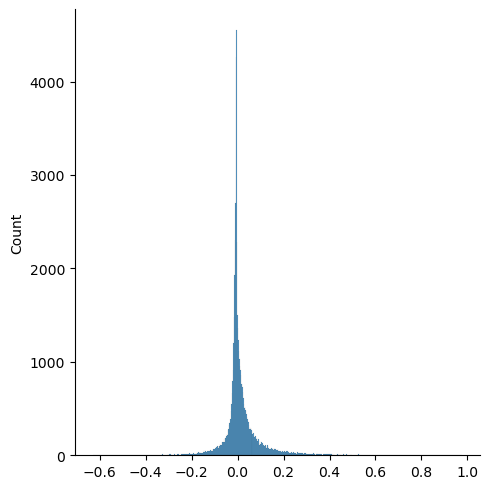

In [202]:
sns.displot(case_corrs.values.flatten())

In [187]:
cut = .1

pos = case_corrs > cut
neg = case_corrs < -cut

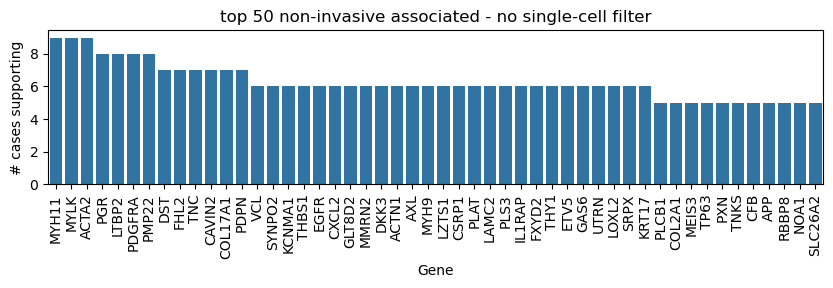

In [188]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(pos.sum(0).sort_values(ascending=False)[:50], ax=ax)
plt.ylabel('# cases supporting')
plt.xlabel('Gene')
plt.title('top 50 non-invasive associated - no single-cell filter')
_ = plt.xticks(rotation=90)

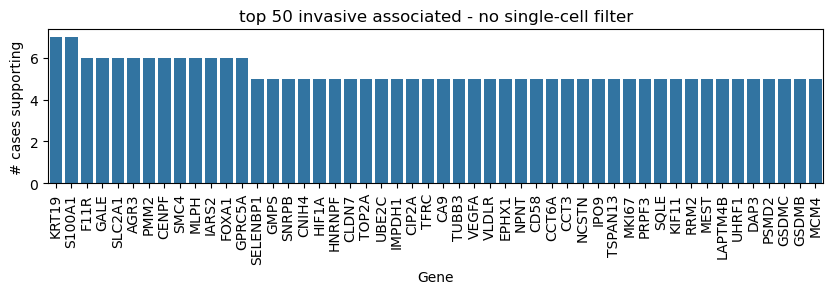

In [189]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(neg.sum(0).sort_values(ascending=False)[:50], ax=ax)
plt.ylabel('# cases supporting')
plt.xlabel('Gene')
plt.title('top 50 invasive associated - no single-cell filter')
_ = plt.xticks(rotation=90)

In [190]:
pos = sample_corrs > cut
neg = sample_corrs < -cut

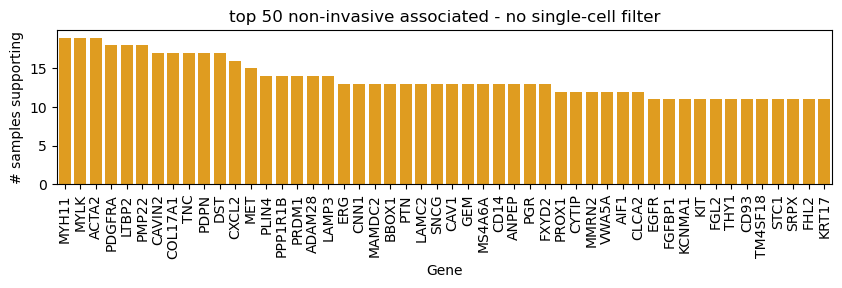

In [191]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(pos.sum(0).sort_values(ascending=False)[:50], color='orange', ax=ax)
plt.ylabel('# samples supporting')
plt.xlabel('Gene')
plt.title('top 50 non-invasive associated - no single-cell filter')
_ = plt.xticks(rotation=90)

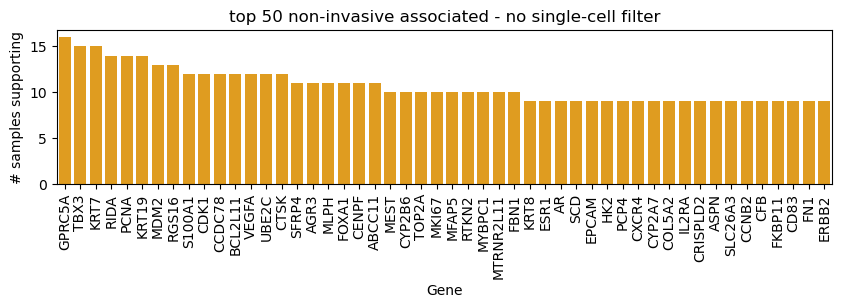

In [192]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(neg.sum(0).sort_values(ascending=False)[:50], color='orange', ax=ax)
plt.ylabel('# samples supporting')
plt.xlabel('Gene')
plt.title('top 50 non-invasive associated - no single-cell filter')
_ = plt.xticks(rotation=90)

In [245]:
sc_degs = pd.read_csv(f'../data/single-cell/degs/{disease}.txt', sep='\t', index_col=0)
sc_degs

scores  logfoldchanges  pvals  pvals_adj
names                                                 
MEIS2      98.328200        5.051916    0.0        0.0
MIR205HG   91.886780        8.452617    0.0        0.0
PCDH7      78.717870        6.919479    0.0        0.0
RBMS3      77.533700        3.028224    0.0        0.0
MCC        76.949450        3.737141    0.0        0.0
...              ...             ...    ...        ...
TMPRSS2  -106.596954       -4.108202    0.0        0.0
AFF3     -112.303260       -5.140292    0.0        0.0
CPNE4    -112.510956       -5.191433    0.0        0.0
KLK2     -113.057110       -4.934494    0.0        0.0
KLK3     -113.811970       -4.955718    0.0        0.0

[30865 rows x 4 columns]

In [246]:
keep = sc_degs[sc_degs['logfoldchanges'] < -.5]
keep_genes = set(keep.index.to_list())
len(keep_genes)

9551

In [247]:
cut = .1


filtered = case_corrs[[k for k in keep_genes if k in case_corrs]]
pos = filtered > cut
neg = filtered < -cut

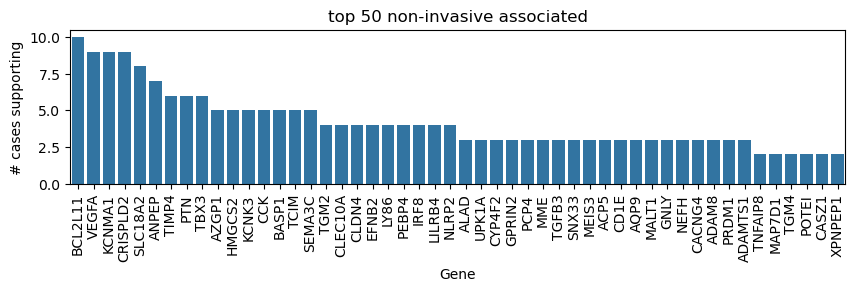

In [248]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(pos.sum(0).sort_values(ascending=False)[:50], ax=ax)
plt.ylabel('# cases supporting')
plt.xlabel('Gene')
plt.title('top 50 non-invasive associated')
_ = plt.xticks(rotation=90)

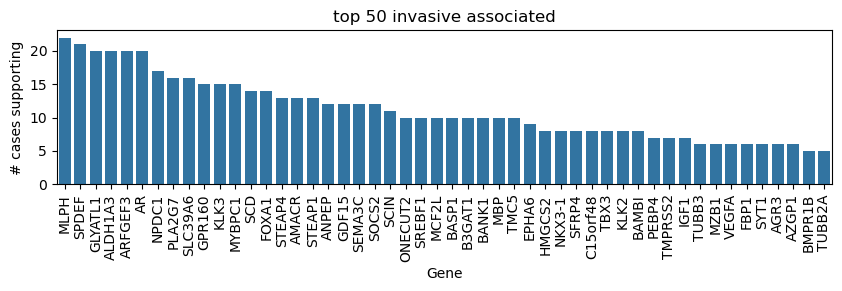

In [249]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(neg.sum(0).sort_values(ascending=False)[:50], ax=ax)
plt.ylabel('# cases supporting')
plt.xlabel('Gene')
plt.title('top 50 invasive associated')
_ = plt.xticks(rotation=90)

In [250]:
filtered = sample_corrs[[k for k in keep_genes if k in case_corrs]]

pos = filtered > cut
neg = filtered < -cut

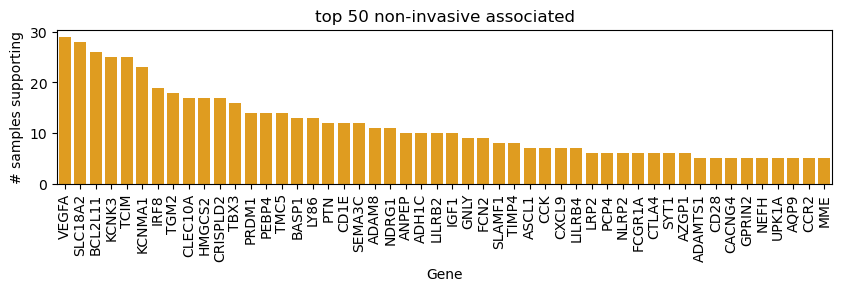

In [251]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(pos.sum(0).sort_values(ascending=False)[:50], color='orange', ax=ax)
plt.ylabel('# samples supporting')
plt.xlabel('Gene')
plt.title('top 50 non-invasive associated')
_ = plt.xticks(rotation=90)

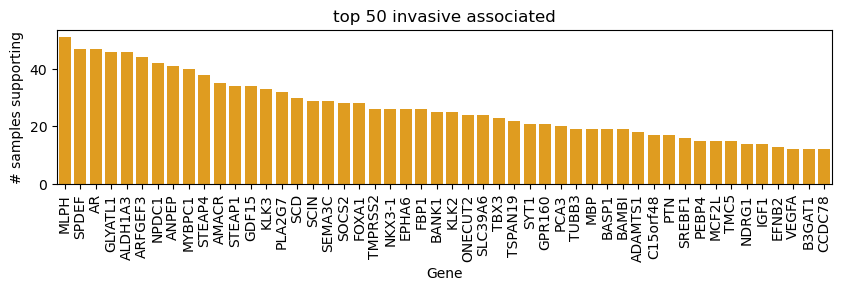

In [252]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(neg.sum(0).sort_values(ascending=False)[:50], color='orange', ax=ax)
plt.ylabel('# samples supporting')
plt.xlabel('Gene')
plt.title('top 50 invasive associated')
_ = plt.xticks(rotation=90)

In [256]:
case_corrs.mean(0).sort_values(ascending=True)

KLK2     -0.375252
KLK3     -0.338337
P4HB     -0.319235
NKX3-1   -0.301811
TRPM4    -0.283469
            ...   
KRT15     0.608793
TP63      0.632434
ITGB4     0.659400
LAMB3     0.747386
KRT5      0.907046
Length: 10464, dtype: float64

In [257]:
sc_degs.loc['NKX3-1']

scores           -52.041780
logfoldchanges    -2.943471
pvals              0.000000
pvals_adj          0.000000
Name: NKX3-1, dtype: float64

In [108]:
adata = adata_from_xenium(meta['storage1_path'][0])
adata

AnnData object with n_obs × n_vars = 712461 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'ome', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [112]:
transcripts = pd.read_parquet(Path(meta['storage1_path'][0]) / 'transcripts.parquet')
transcripts

transcript_id     cell_id  overlaps_nucleus feature_name  \
0         281904473446395  UNASSIGNED                 0        BASP1   
1         281904473451784  UNASSIGNED                 0      BCL2L11   
2         281904473453881  UNASSIGNED                 0         CNN1   
3         281904473453895  UNASSIGNED                 0        SPDEF   
4         281904473454967  UNASSIGNED                 0         MDM2   
...                   ...         ...               ...          ...   
61809451  281784214406952  UNASSIGNED                 0          DES   
61809452  281784214472635  UNASSIGNED                 0       APCDD1   
61809453  281852933869318  UNASSIGNED                 0         AQP3   
61809454  281852933877707  UNASSIGNED                 0   BLANK_0461   
61809455  281852933846163  UNASSIGNED                 0         ELF5   

            x_location    y_location  z_location         qv fov_name  \
0           185.625061    749.730286   11.712227  40.000000       O2   
1            63.267475    743.823914   11.639360  40.000000       O2   
2           113.691795    729.325317   11.540667  40.000000       O2   
3           211.883453    742.729126   11.654253  40.000000       O2   
4             8.796597    740.116821   11.702969  40.000000       O2   
...                ...           ...         ...        ...      ...   
61809451  10251.851562  12859.289062   23.141520  40.000000     AE18   
61809452  10252.987305  12763.015625   23.185917  40.000000     AE18   
61809453  10256.611328  13439.599609   23.971735  36.962391     AF18   
61809454  10257.065430  13439.661133   23.873138  17.207663     AF18   
61809455  10253.712891  13620.455078   23.567816  40.000000     AF18   

          nucleus_distance  
0               348.990784  
1               435.068970  
2               409.799103  
3               340.554657  
4               479.120667  
...                    ...  
61809451        273.151886  
61809452        266.756561  
61809453        373.716125  
61809454        374.171234  
61809455        415.275330  

[61809456 rows x 10 columns]

In [124]:
img, genes = tile_xenium(adata, tile_size=10, transcripts=transcripts)


In [140]:
np.save('../../sandbox/test.npy', img)

In [143]:
json.dump(genes, open('../../sandbox/test.json', 'w'))

In [144]:
json.load(open('../../sandbox/test.json'))

['ABCC11',
 'ACE2',
 'ACKR1',
 'ACTA2',
 'ACTG2',
 'ADAM28',
 'ADAMTS1',
 'ADGRE1',
 'ADGRL4',
 'ADH1C',
 'ADH4',
 'ADIPOQ',
 'AGER',
 'AGR3',
 'AHSP',
 'AIF1',
 'ALAS2',
 'ALDH1A3',
 'AMY2A',
 'ANGPT2',
 'ANPEP',
 'APCDD1',
 'APOA5',
 'APOBEC3A',
 'APOLD1',
 'AQP2',
 'AQP3',
 'AQP8',
 'AQP9',
 'AR',
 'ARFGEF3',
 'ASCL1',
 'ASCL3',
 'ASPN',
 'BAMBI',
 'BANK1',
 'BASP1',
 'BBOX1',
 'BCL2L11',
 'BLANK_0006',
 'BLANK_0037',
 'BLANK_0069',
 'BLANK_0400',
 'BLANK_0401',
 'BLANK_0402',
 'BLANK_0403',
 'BLANK_0404',
 'BLANK_0405',
 'BLANK_0406',
 'BLANK_0407',
 'BLANK_0408',
 'BLANK_0409',
 'BLANK_0410',
 'BLANK_0411',
 'BLANK_0412',
 'BLANK_0413',
 'BLANK_0414',
 'BLANK_0415',
 'BLANK_0416',
 'BLANK_0417',
 'BLANK_0418',
 'BLANK_0419',
 'BLANK_0420',
 'BLANK_0421',
 'BLANK_0422',
 'BLANK_0423',
 'BLANK_0424',
 'BLANK_0425',
 'BLANK_0426',
 'BLANK_0427',
 'BLANK_0428',
 'BLANK_0429',
 'BLANK_0430',
 'BLANK_0431',
 'BLANK_0432',
 'BLANK_0433',
 'BLANK_0434',
 'BLANK_0435',
 'BLANK_0436',
 'BLA

In [133]:
x = img / img.sum((0, 1), keepdims=True)
x.shape

(1376, 1028, 480)

In [138]:
1 / 100000

1e-05

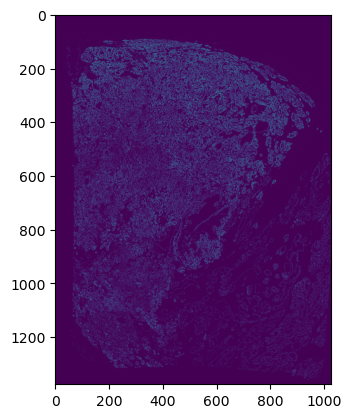

In [134]:
plt.imshow(x[..., idx])

In [126]:
img.shape

(1376, 1028, 480)

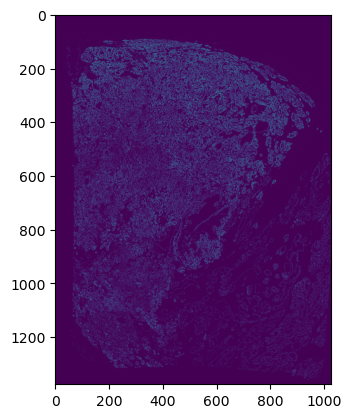

In [128]:
idx = genes.index('EPCAM')
plt.imshow(img[..., idx])

In [127]:
genes

['ABCC11',
 'ACE2',
 'ACKR1',
 'ACTA2',
 'ACTG2',
 'ADAM28',
 'ADAMTS1',
 'ADGRE1',
 'ADGRL4',
 'ADH1C',
 'ADH4',
 'ADIPOQ',
 'AGER',
 'AGR3',
 'AHSP',
 'AIF1',
 'ALAS2',
 'ALDH1A3',
 'AMY2A',
 'ANGPT2',
 'ANPEP',
 'APCDD1',
 'APOA5',
 'APOBEC3A',
 'APOLD1',
 'AQP2',
 'AQP3',
 'AQP8',
 'AQP9',
 'AR',
 'ARFGEF3',
 'ASCL1',
 'ASCL3',
 'ASPN',
 'BAMBI',
 'BANK1',
 'BASP1',
 'BBOX1',
 'BCL2L11',
 'BLANK_0006',
 'BLANK_0037',
 'BLANK_0069',
 'BLANK_0400',
 'BLANK_0401',
 'BLANK_0402',
 'BLANK_0403',
 'BLANK_0404',
 'BLANK_0405',
 'BLANK_0406',
 'BLANK_0407',
 'BLANK_0408',
 'BLANK_0409',
 'BLANK_0410',
 'BLANK_0411',
 'BLANK_0412',
 'BLANK_0413',
 'BLANK_0414',
 'BLANK_0415',
 'BLANK_0416',
 'BLANK_0417',
 'BLANK_0418',
 'BLANK_0419',
 'BLANK_0420',
 'BLANK_0421',
 'BLANK_0422',
 'BLANK_0423',
 'BLANK_0424',
 'BLANK_0425',
 'BLANK_0426',
 'BLANK_0427',
 'BLANK_0428',
 'BLANK_0429',
 'BLANK_0430',
 'BLANK_0431',
 'BLANK_0432',
 'BLANK_0433',
 'BLANK_0434',
 'BLANK_0435',
 'BLANK_0436',
 'BLA

In [111]:
adata.obsm['spatial']

array([10267, 13616])

In [98]:
import json
json.load(open('/storage1/fs1/dinglab/Active/Primary/HTAN.Imaging/xenium/data/20230830__153957__20230830_24001/output-XETG00122__0011120__S18-15142Fp1Us1_1__20230830__154053/experiment.xenium'))



{'major_version': 2,
 'minor_version': 0,
 'patch_version': 1,
 'run_name': '20230830_24001',
 'run_start_time': '2023-08-30T15:39:57Z',
 'region_name': 'S18-15142Fp1Us1_1',
 'preservation_method': 'ffpe',
 'num_cells': 720423,
 'transcripts_per_cell': 61,
 'transcripts_per_100um': 54.27619697251237,
 'cassette_name': 'Prostate_PKD',
 'slide_id': '0011120',
 'panel_design_id': 'hMulti_v1',
 'panel_name': 'Xenium Human Multi-Tissue and Cancer Gene Expression',
 'panel_organism': 'Human',
 'panel_tissue_type': 'Multi',
 'panel_num_targets_predesigned': 377,
 'panel_num_targets_custom': 0,
 'pixel_size': 0.2125,
 'instrument_sn': 'XETG00122',
 'instrument_sw_version': '1.5.2.0',
 'analysis_sw_version': 'xenium-1.5.0.3',
 'analysis_uuid': '76e4a29c-674c-43a6-8e95-041e1ba6b20d',
 'experiment_uuid': 'c63ea835-d347-46e5-bc16-d40de420c14b',
 'cassette_uuid': '6edd7209-5d3f-42a5-8bee-7ff5bd504085',
 'roi_uuid': '02869350-7aac-4e2c-82d4-c00738285e89',
 'z_step_size': 3.0,
 'well_uuid': 'def_41af

In [ ]:
tiling_size = 10

for fp in fps:
    name = fp.split('/')[-1]
    sid = name.split('__')[2]
    print(sid)
    adata = xenium.adata_from_xenium(fp)
    
    if adata.shape[1] < 2000:
        transcripts_fp = Path(fp) / 'transcripts.parquet'
        assert os.path.exists(transcripts_fp)
        transcripts = pd.read_parquet(transcripts_fp)

        img, tiled_channels = tiling_utils.tile_xenium(adata, tile_size=tiling_size, transcripts=transcripts)
    else:
        img = tiling_utils.tile_xenium(adata, tile_size=tiling_size)
        tiled_channels = adata.var.index.to_list()
        
    if img.dtype != np.uint8:
        img = img - img.min((0, 1), keepdims=True)
        img = img / img.max((0, 1), keepdims=True)
        img = img * 255
        img = img.astype(np.uint8)
    img = rearrange(img, 'h w c -> c h w')
    
    tifffile.imwrite(save_dir / f'{sid}_tiled.tif', img, compression='LZW')
    
    
    meta = {
        'channels': list(tiled_channels),
        'sid': sid
    }
    yaml.safe_dump(meta, open(save_dir / f'{sid}_metadata.yaml', 'w'))

In [3]:
# ## transfer to compute1, run from katmai
# adata = None
# for i, row in meta.iterrows():
    
#     counts_fp = Path(row['katmai_path']) / 'cell_feature_matrix.h5'
#     boundaries_fp = Path(row['katmai_path']) / 'cell_boundaries.parquet'
#     sid = row['Section_ID_clean']
#     print(f'scp {counts_fp} estorrs@compute1-client-1.ris.wustl.edu:/storage1/fs1/dinglab/Active/Projects/estorrs/3d-analysis/data/spatial/inputs/xenium/{sid}_cell_feature_matrix.h5')
#     print(f'scp {boundaries_fp} estorrs@compute1-client-1.ris.wustl.edu:/storage1/fs1/dinglab/Active/Projects/estorrs/3d-analysis/data/spatial/inputs/xenium/{sid}_cell_boundaries.parquet')

In [4]:
directory = Path('../data/spatial/inputs/xenium')
fps = [directory / fname for fname in os.listdir(directory) if 'cell_feature_matrix.h5' in fname or 'cell_boundaries.parquet' in fname]
fps

[PosixPath('../data/spatial/inputs/xenium/SP016Z1-Fp1B28U2_cell_feature_matrix.h5'),
 PosixPath('../data/spatial/inputs/xenium/HT206B1-H2L1Us1_9_cell_boundaries.parquet'),
 PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U104_cell_feature_matrix.h5'),
 PosixPath('../data/spatial/inputs/xenium/SP048Z1-Fp1C27U1_cell_boundaries.parquet'),
 PosixPath('../data/spatial/inputs/xenium/SP008Z1-Fp1F15U1_cell_boundaries.parquet'),
 PosixPath('../data/spatial/inputs/xenium/HT704B1-S1H3Fp1U1_cell_feature_matrix.h5'),
 PosixPath('../data/spatial/inputs/xenium/HT913Z1-S2H1Fp1U101_cell_boundaries.parquet'),
 PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U44_cell_feature_matrix.h5'),
 PosixPath('../data/spatial/inputs/xenium/HT704B1-S1H3Fp1U17_cell_boundaries.parquet'),
 PosixPath('../data/spatial/inputs/xenium/1661918aU1_cell_boundaries.parquet'),
 PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U69_cell_feature_matrix.h5'),
 PosixPath('../data/spatial/inputs/xenium/HT1011Z1-

In [5]:
sid_to_paths = {}
for fp in fps:
    sid = str(fp.absolute()).split('/')[-1]
    sid = sid.replace('_cell_boundaries.parquet', '').replace('_cell_feature_matrix.h5', '')
    is_features = '_cell_boundaries.parquet' not in str(fp)
    
    if sid not in sid_to_paths:
        sid_to_paths[sid] = {}
    
    if is_features:
        sid_to_paths[sid]['features'] = fp
    else:
        sid_to_paths[sid]['boundaries'] = fp
sid_to_paths

{'SP016Z1-Fp1B28U2': {'features': PosixPath('../data/spatial/inputs/xenium/SP016Z1-Fp1B28U2_cell_feature_matrix.h5'),
  'boundaries': PosixPath('../data/spatial/inputs/xenium/SP016Z1-Fp1B28U2_cell_boundaries.parquet')},
 'HT206B1-H2L1Us1_9': {'boundaries': PosixPath('../data/spatial/inputs/xenium/HT206B1-H2L1Us1_9_cell_boundaries.parquet'),
  'features': PosixPath('../data/spatial/inputs/xenium/HT206B1-H2L1Us1_9_cell_feature_matrix.h5')},
 'HT891Z1-S2H3Fp1U104': {'features': PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U104_cell_feature_matrix.h5'),
  'boundaries': PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U104_cell_boundaries.parquet')},
 'SP048Z1-Fp1C27U1': {'boundaries': PosixPath('../data/spatial/inputs/xenium/SP048Z1-Fp1C27U1_cell_boundaries.parquet'),
  'features': PosixPath('../data/spatial/inputs/xenium/SP048Z1-Fp1C27U1_cell_feature_matrix.h5')},
 'SP008Z1-Fp1F15U1': {'boundaries': PosixPath('../data/spatial/inputs/xenium/SP008Z1-Fp1F15U1_cell_boundarie

In [6]:
sid_to_adata_fp = {}
for sid, d in sid_to_paths.items():
    print(sid)
    adata = sc.read_10x_h5(d['features'])
    boundaries = pd.read_parquet(d['boundaries'])
    boundaries = boundaries[['cell_id', 'vertex_x', 'vertex_y']].groupby('cell_id').mean()
    adata.obs = pd.merge(adata.obs, boundaries, left_index=True, right_index=True)
    adata.obsm['spatial'] = adata.obs.values

    adata.obs['barcode'] = adata.obs.index.to_list()
    adata.obs['sid'] = sid
    adata.obs.index = [f'{sid}_{x}' for x in adata.obs.index]

    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=5)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
    
    adata.write_h5ad(directory / f'{sid}.h5ad')
    
    sid_to_adata_fp[sid] = directory / f'{sid}.h5ad'
    
    del(adata)

sid_to_adata_fp
    
    

SP016Z1-Fp1B28U2
HT206B1-H2L1Us1_9
HT891Z1-S2H3Fp1U104
SP048Z1-Fp1C27U1
SP008Z1-Fp1F15U1
HT704B1-S1H3Fp1U1
HT913Z1-S2H1Fp1U101
HT891Z1-S2H3Fp1U44
HT704B1-S1H3Fp1U17
1661918aU1
HT891Z1-S2H3Fp1U69
HT1011Z1-S1H3Fp1U1
HT206B1-H2L1Us1_24
SP048Z1-Fp1C27U2
HT913Z1-S1H1Fp1U11
SP006Z1-Fp1C8Us2_1
HT206B1-H2L1Us1_17
SP004Z1-Fp1B17Us2_1
HT913Z1-S2H1Fp1U35
HT891Z1-S2H3Fp1U1
HT849Z1-S1H2Fp1U1
SP017Z1-Fp1B27Us1_17
HT891Z1-S2H3Fp1U59
HT913Z1-S2H1Fp1U61
HT913Z1-S2H1Fp1U33
SP006Z1-Fp1C8Us2_7
SP015Z1-Fp1A1U3
SP051Z1-Fp1F1U2
SP006Z1-Fp1C8Us1_1
SP011Z1-Fp1-A15U1
HT891Z1-S2H3Fp1U81
HT852Z1-S1H1Fp1U1
1607059U1
HT814Z1-S1H1Fp1Us1_3
HT913Z1-S2H1Fp1U34
HT591B1-S1H1Fp1Us1_1
HT913Z1-S2H1Fp1U11
HT832Z1-S1H1Fp1U1
SP014Z1-Fp1A29U1
HT832Z1-S1H1Fp1U2
HT817Z1-S1H1Fp1Us1_2
SP009Z1-Fp1B14U1
HT206B1-H2L1Us1_15
SP003Z1-Fp1Us1_1
SP006Z1-Fp1C8Us2_20
SP017Z1-Fp1B27Us1_24
SP006Z1-Fp1C8Us2_5
HT891Z1-S2H3Fp1U21
SP005Z1-Fp1A25Us1_1
1654977AU1
SP006Z1-Fp1C8Us2_18
SP017Z1-Fp1B27Us1_2
HT913Z1-S2H1Fp1U1
SP050Z1-Fp1A1U2
SP016Z1-Fp1B28

{'SP016Z1-Fp1B28U2': PosixPath('../data/spatial/inputs/xenium/SP016Z1-Fp1B28U2.h5ad'),
 'HT206B1-H2L1Us1_9': PosixPath('../data/spatial/inputs/xenium/HT206B1-H2L1Us1_9.h5ad'),
 'HT891Z1-S2H3Fp1U104': PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U104.h5ad'),
 'SP048Z1-Fp1C27U1': PosixPath('../data/spatial/inputs/xenium/SP048Z1-Fp1C27U1.h5ad'),
 'SP008Z1-Fp1F15U1': PosixPath('../data/spatial/inputs/xenium/SP008Z1-Fp1F15U1.h5ad'),
 'HT704B1-S1H3Fp1U1': PosixPath('../data/spatial/inputs/xenium/HT704B1-S1H3Fp1U1.h5ad'),
 'HT913Z1-S2H1Fp1U101': PosixPath('../data/spatial/inputs/xenium/HT913Z1-S2H1Fp1U101.h5ad'),
 'HT891Z1-S2H3Fp1U44': PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U44.h5ad'),
 'HT704B1-S1H3Fp1U17': PosixPath('../data/spatial/inputs/xenium/HT704B1-S1H3Fp1U17.h5ad'),
 '1661918aU1': PosixPath('../data/spatial/inputs/xenium/1661918aU1.h5ad'),
 'HT891Z1-S2H3Fp1U69': PosixPath('../data/spatial/inputs/xenium/HT891Z1-S2H3Fp1U69.h5ad'),
 'HT1011Z1-S1H3Fp1U1': Posi

## do cell typing

In [37]:
input_fp = '../data/spatial/inputs/xenium/SP016Z1-Fp1B28U2.h5ad'

output_fp = input_fp.replace('.h5ad', '_processed.h5ad')

In [38]:
adata = sc.read_h5ad(input_fp)
adata

AnnData object with n_obs × n_vars = 501536 × 5101
    obs: 'vertex_x', 'vertex_y', 'barcode', 'sid', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

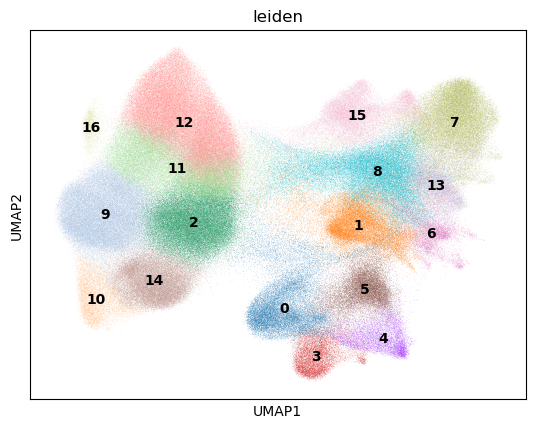

In [41]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

In [47]:
mapping = {
    'Epithelial': [16, 12, 11, 9, 2, 14, 10],
    'Basal': [5],
    'Endothelial': [15],
    'Immune': [1],
    'Fibroblast': [7]
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
adata.obs['cell_type_macro'] = [r_mapping.get(int(x), 'Other') for x in adata.obs['leiden']]

In [63]:
# sc.pl.umap(adata, color='cell_type_macro')

In [62]:
# sns.scatterplot(
#     x=adata.obsm['spatial'][:, 0],
#     y=adata.obsm['spatial'][:, 1],
#     hue=adata.obs['cell_type_macro'],
#     s=.1
# )

In [61]:
# adata.obs['highlight'] = [str(x=='Fibroblast') for x in adata.obs['cell_type_macro']]
# sns.scatterplot(
#     x=adata.obsm['spatial'][:, 0],
#     y=adata.obsm['spatial'][:, 1],
#     hue=adata.obs['highlight'],
#     s=.1
# )

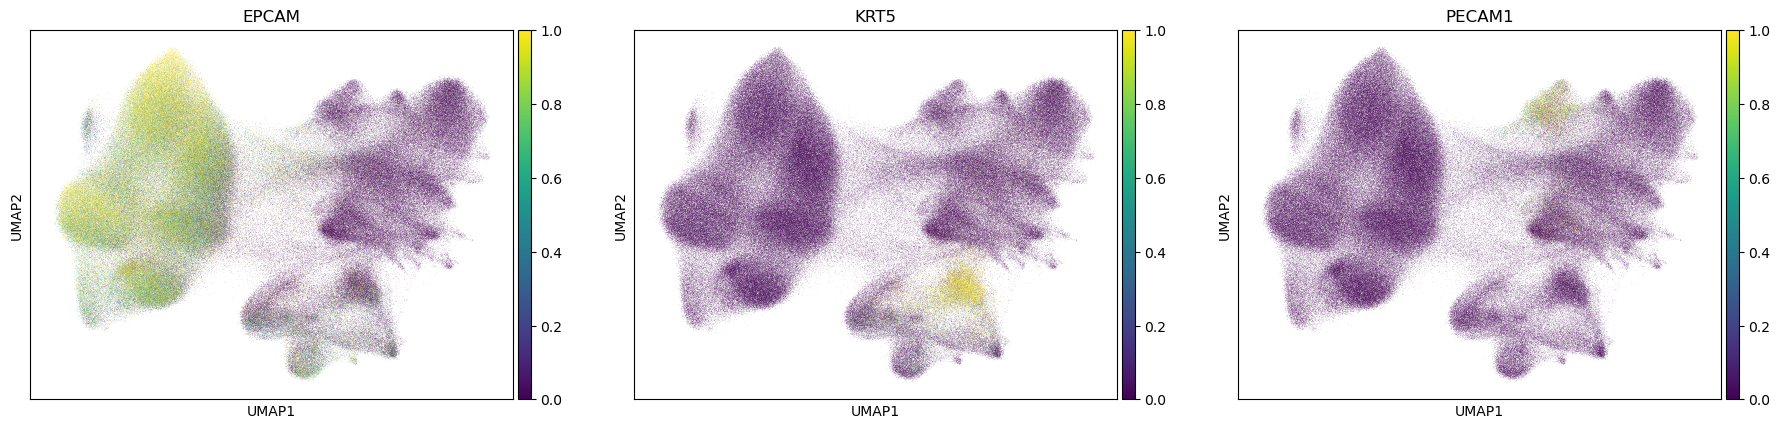

In [39]:
sc.pl.umap(adata, color=['EPCAM', 'KRT5', 'PECAM1'], vmax=1)

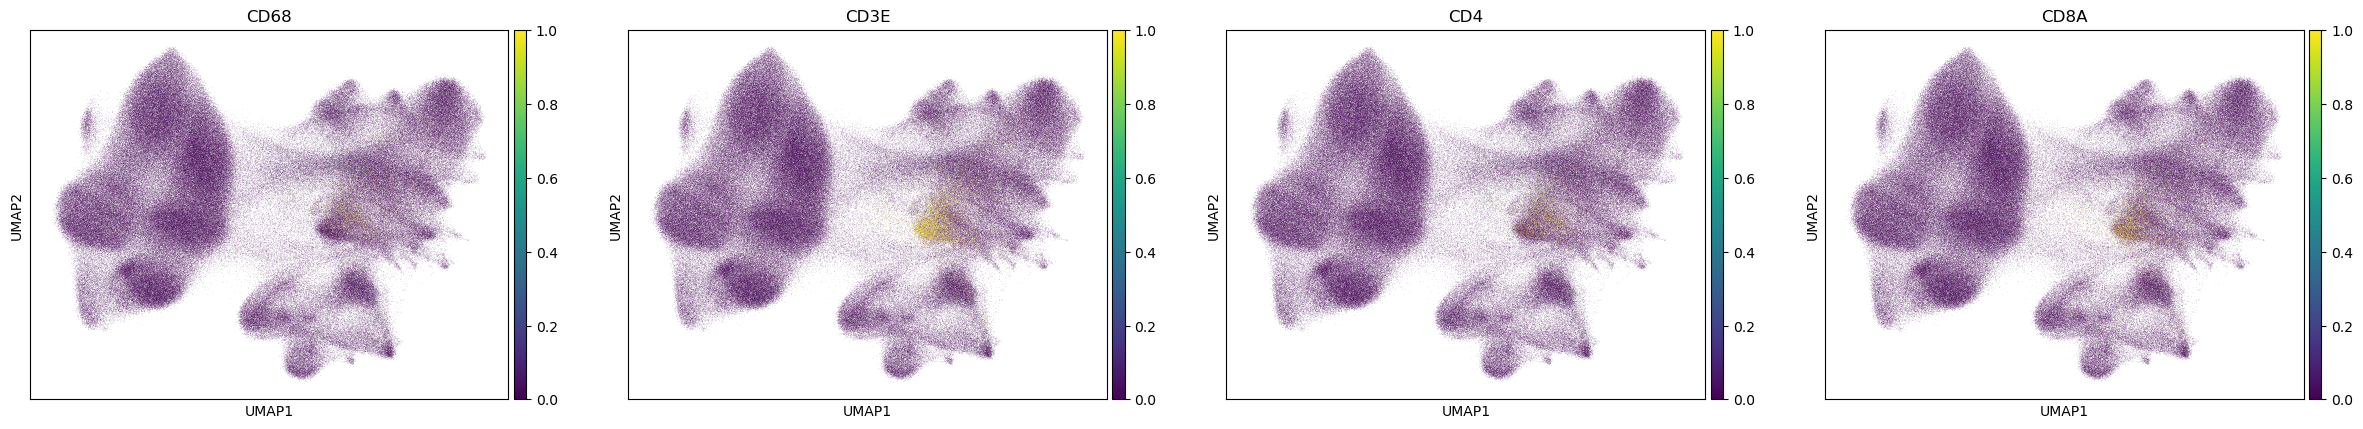

In [26]:
sc.pl.umap(adata, color=['CD68', 'CD3E', 'CD4', 'CD8A'], vmax=1)

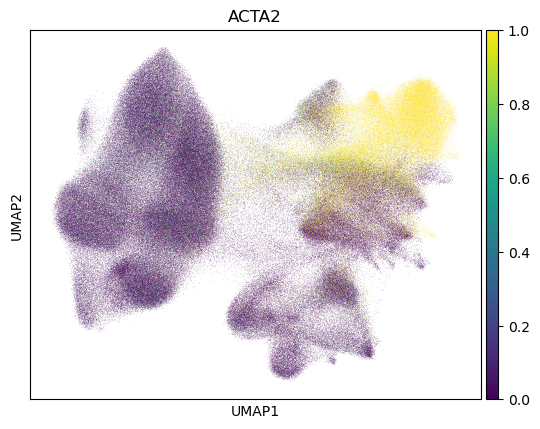

In [42]:
sc.pl.umap(adata, color=['ACTA2'], vmax=1)

In [66]:
immune = adata[adata.obs['cell_type_macro']=='Immune'].copy()
sc.pp.pca(immune)
sc.pp.neighbors(immune)
sc.tl.umap(immune)
sc.tl.leiden(immune, flavor='igraph', n_iterations=2)
immune

AnnData object with n_obs × n_vars = 32846 × 5101
    obs: 'vertex_x', 'vertex_y', 'barcode', 'sid', 'n_counts', 'leiden', 'cell_type_macro', 'highlight'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'leiden_colors', 'cell_type_macro_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

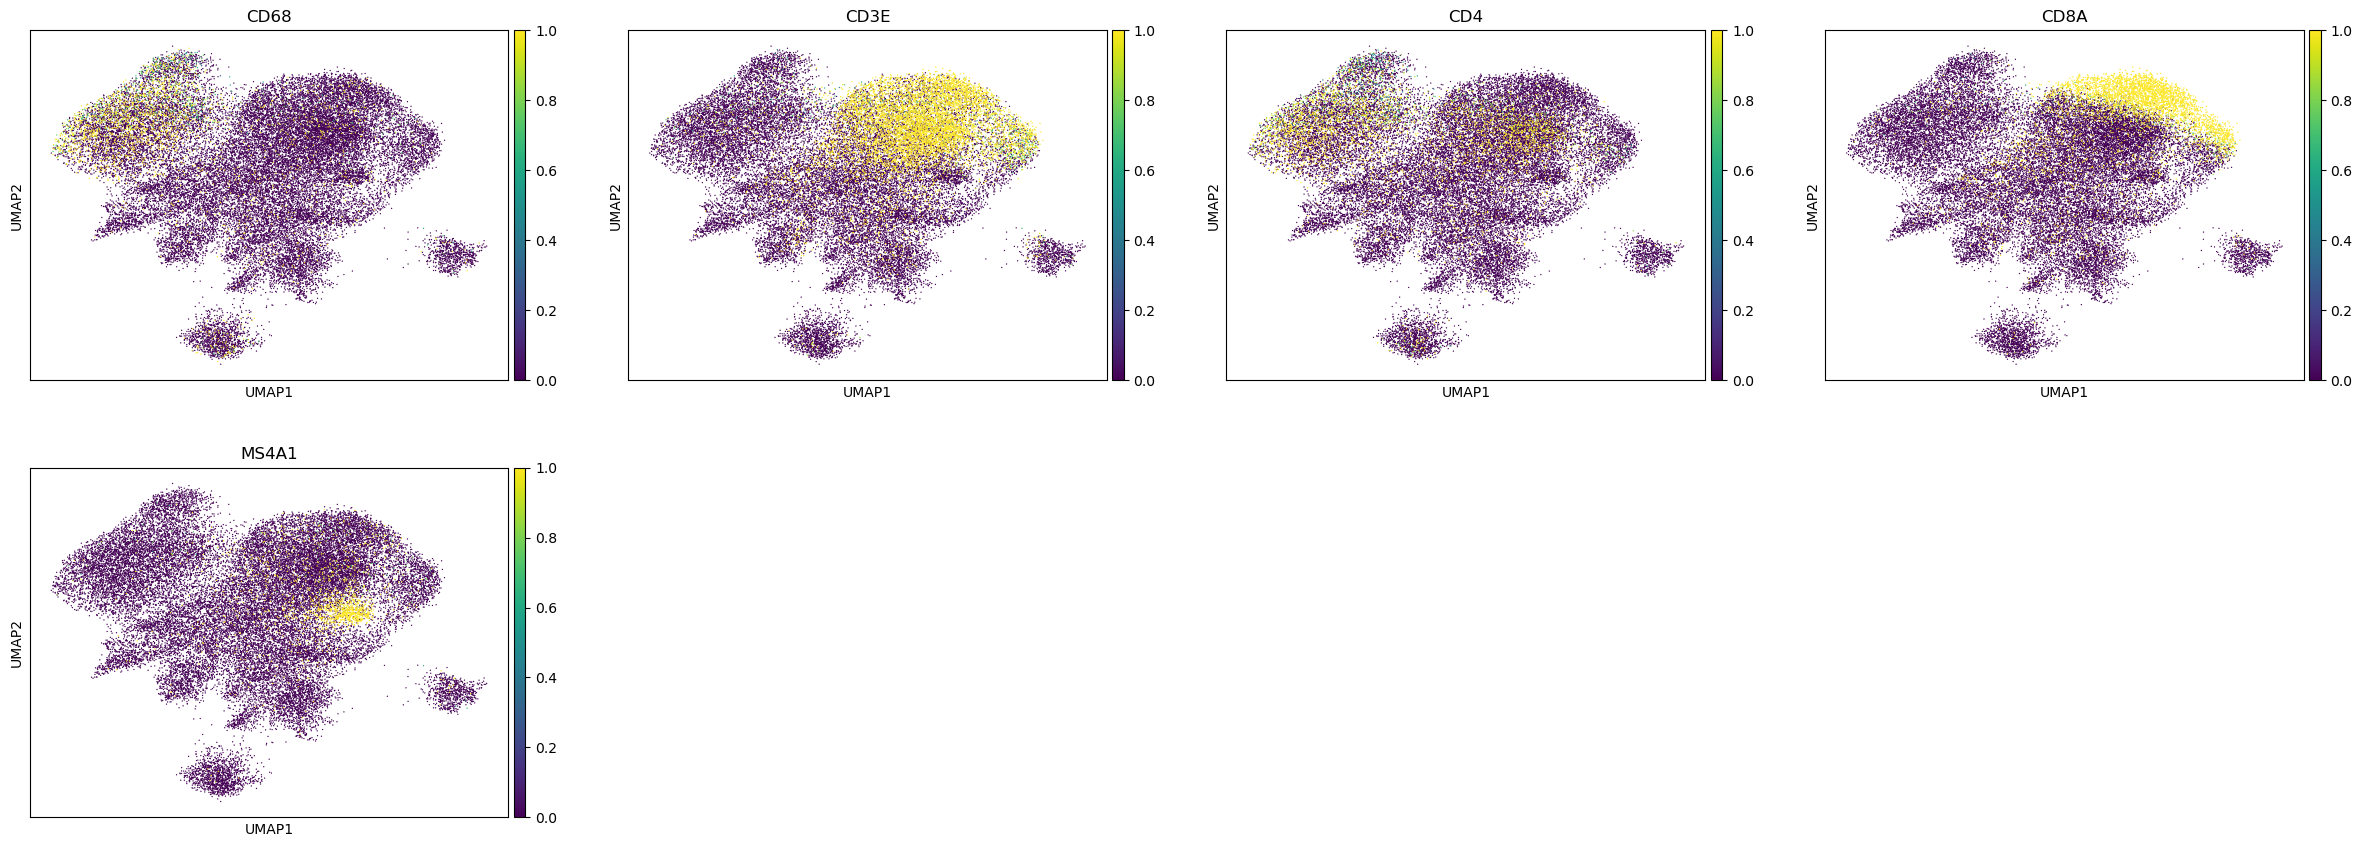

In [74]:
sc.pl.umap(immune, color=['CD68', 'CD3E', 'CD4', 'CD8A', 'MS4A1'], vmax=1)

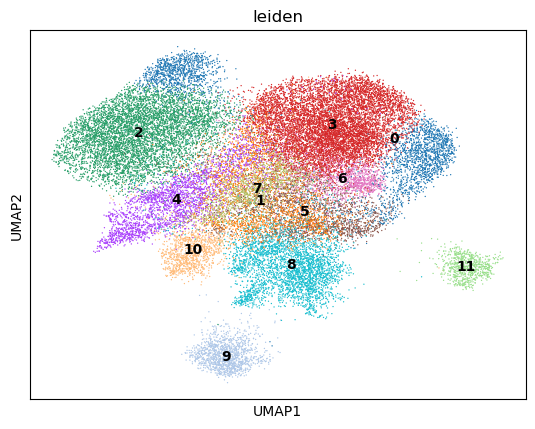

In [75]:
sc.pl.umap(immune, color=['leiden'], vmax=1, legend_loc='on data')

In [76]:
mapping = {
    'T cell': [3],
    'Macrophage': [2],
    'B cell': [5],
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
barcode_to_ct = {b:r_mapping.get(int(x), 'Immune - other')
                 for b, x in zip(immune.obs.index.to_list(), immune.obs['leiden'])}
adata.obs['cell_type'] = [barcode_to_ct.get(b, cell_type)
                          for b, cell_type in zip(adata.obs.index.to_list(), adata.obs['cell_type_macro'])]

                                                                                 
                                                                                 
                                                                                 

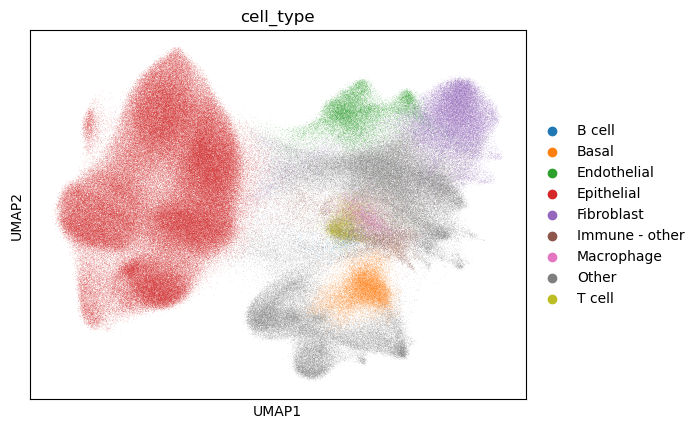

In [77]:
sc.pl.umap(adata, color='cell_type')

<Axes: >

/miniconda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/miniconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


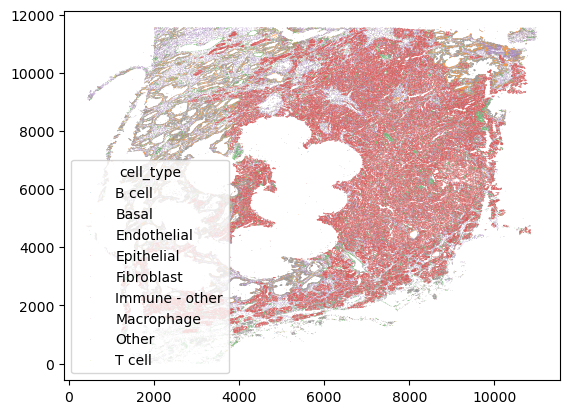

In [78]:
sns.scatterplot(
    x=adata.obsm['spatial'][:, 0],
    y=adata.obsm['spatial'][:, 1],
    hue=adata.obs['cell_type'],
    s=.1
)

In [79]:
adata.write_h5ad(input_fp.replace('.h5ad', '_cell_typed.h5ad'))
immune.write_h5ad(input_fp.replace('.h5ad', '_immune.h5ad'))

In [123]:
import os
import re
import json
import pickle 
import shutil
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import tifffile
from einops import rearrange, repeat
from ome_types import from_xml, to_dict
from pydantic_extra_types.color import Color
from torchvision.transforms import InterpolationMode

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.visualization.tiling_utils as tiling_utils

In [5]:
save_dir = Path('../data/spatial/xenium/')
save_dir.mkdir(parents=True, exist_ok=True)

In [6]:
meta = pd.read_csv(
    '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v3/supplement/xenium_tracking.txt',
    sep='\t'
)
meta = meta[['Section_ID_clean', 'Block_ID', 'Site', 'sample_run_name', 'katmai_path']]
meta

Section_ID_clean         Block_ID      Site  \
0       SP003Z1-Fp1Us1_1    S18-15142-B17  Prostate   
1   SP017Z1-Fp1B27Us1_17     S18-9906-B27  Prostate   
2    SP017Z1-Fp1B27Us1_2     S18-9906-B27  Prostate   
3   SP017Z1-Fp1B27Us1_24     S18-9906-B27  Prostate   
4    SP017Z1-Fp1B27Us1_9     S18-9906-B27  Prostate   
..                   ...              ...       ...   
70             1607059U1          1607059    Breast   
71     HT944B1-S2H2bFpU1  HT944B1-S2H2bFp    Breast   
72      SP048Z1-Fp1C27U2     S18-5929-C27  Prostate   
73       SP051Z1-Fp1F1U2     S20-23195-F1  Prostate   
74       SP050Z1-Fp1A1U2     S23-27043-A1  Prostate   

                                      sample_run_name  \
0   output-XETG00122__0011120__S18-15142Fp1Us1_1__...   
1   output-XETG00122__0010784__S18-9906-B27Us1_17Q...   
2   output-XETG00122__0010784__S18-9906-B27Us1_2Q1...   
3   output-XETG00122__0010787__S18-9906-B27Us1_24Q...   
4   output-XETG00122__0010787__S18-9906-B27Us1_9Q1...   
..                                                ...   
70  output-XETG00523__0037628__1607059U1__20250124...   
71  output-XETG00523__0037640__HT944B1-S2H2bFpU1__...   
72  output-XETG00122__0033872__S18-5929-C27U2__202...   
73  output-XETG00122__0033872__S20-23195-F1U2__202...   
74  output-XETG00122__0033871__S23-27043-A1U2__202...   

                                          katmai_path  
0   /diskmnt/primary/Xenium/data/20230830__153957_...  
1   /diskmnt/primary/Xenium/data/20230912__220334_...  
2   /diskmnt/primary/Xenium/data/20230912__220334_...  
3   /diskmnt/primary/Xenium/data/20230912__220334_...  
4   /diskmnt/primary/Xenium/data/20230912__220334_...  
..                                                ...  
70  /diskmnt/primary/Xenium/data/20250124__222618_...  
71  /diskmnt/primary/Xenium/data/20250124__222618_...  
72  /diskmnt/primary/Xenium/data/20240516__213831_...  
73  /diskmnt/primary/Xenium/data/20240516__213831_...  
74  /diskmnt/primary/Xenium/data/20240516__213831_...  

[75 rows x 5 columns]

In [133]:
for z in [x.split('-')[0] for x in meta['Section_ID_clean']]: print(z)

SP003Z1
SP017Z1
SP017Z1
SP017Z1
SP017Z1
SP003Z1
SP004Z1
SP005Z1
SP006Z1
SP008Z1
SP009Z1
SP012Z1
SP015Z1
SP006Z1
SP006Z1
SP006Z1
SP006Z1
SP006Z1
SP006Z1
HT814Z1
HT817Z1
SP007Z1
HT832Z1
SP016Z1
HT849Z1
HT852Z1
SP011Z1
SP014Z1
HT891Z1
HT891Z1
HT891Z1
HT891Z1
HT891Z1
HT891Z1
HT891Z1
HT891Z1
HT891Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
HT913Z1
SP048Z1
SP016Z1
HT832Z1
HT1011Z1
HT206B1
HT206B1
HT206B1
HT206B1
HT206B1
HT206B1
HT591B1
HT704B1
HT704B1
HT704B1
HT704B1
HT704B1
HT704B1
1581620AU1
1654977AU1
HT727B1
1661918aU1
1607059U1
HT944B1
SP048Z1
SP051Z1
SP050Z1


In [7]:
len(set(meta['Section_ID_clean']))

75

## file munging

In [51]:
for i, row in meta.iterrows():
    sid = row['Section_ID_clean']
    print(sid)
    path = Path(row['katmai_path'])
    transcripts_fp = path / 'transcripts.parquet'
    assert os.path.exists(transcripts_fp), f'{fp} does not exist'
    
    focus_dir = path / 'morphology_focus'
    if focus_dir.exists():
        names = sorted([name for name in os.listdir(focus_dir) if '.tif' in name])
        if names:
            middle = len(names) // 2
            morph_fp = focus_dir / names[middle]
    elif (path / 'morphology_focus.ome.tif').exists():
        morph_fp = path / 'morphology_focus.ome.tif'
    else:
        morph_fp = path / 'morphology.ome.tif'
    assert morph_fp.exists(), f'No morphology file found: {morph_fp}'
    print(morph_fp)
    
    # need to rewrite ome because it is part of an ome series, also saving as pyramidal and uint8
    channels, data = multiplex.extract_ome_tiff(morph_fp, as_dict=False)
    mpp = multiplex.pixels_per_micron(morph_fp)
    
    directory = save_dir / sid
    directory.mkdir(parents=True, exist_ok=True)
    shutil.copy(transcripts_fp, directory / f'transcripts.parquet')
    multiplex.write_basic_ome_tiff(
        directory / f'morphology.ome.tif',
        data, channels, microns_per_pixel=mpp, subresolutions=5
    )